# Step 0: Explore the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<Axes: >

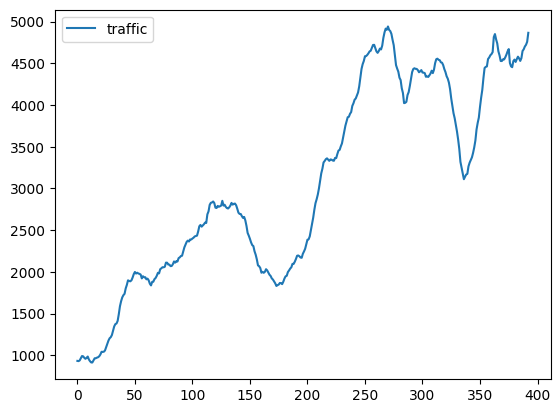

In [ ]:
import pandas as pd
df = pd.read_csv('/content/website_data.csv')
df.info()

df.plot()

<Axes: >

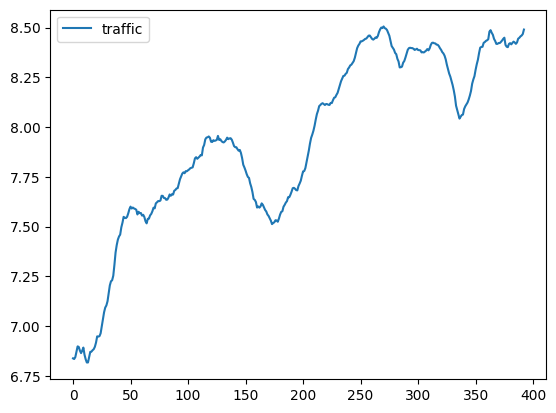

In [ ]:
import numpy as np
df = np.log(df) # don't forget to transform the data back when making real predictions

df.plot()

In [ ]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

# Step 1: Check for stationarity of time series

## Method #1: time series plot

## Method #2: ACF plot and PACF plot

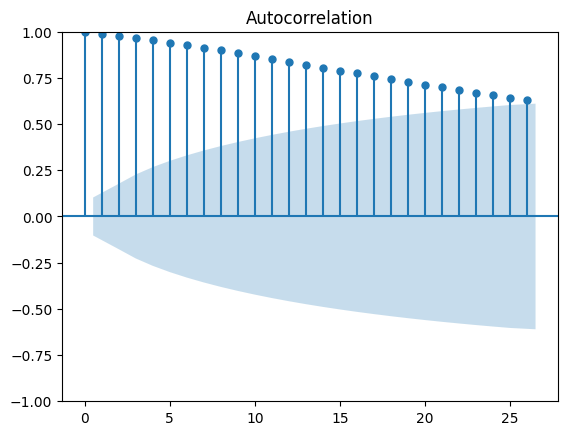

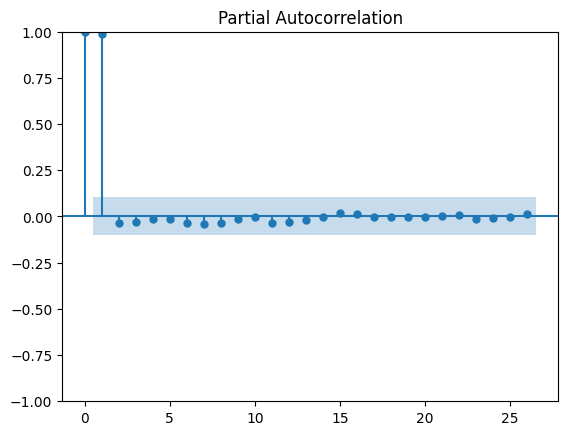

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.24126116082883475


## Transform to stationary: differencing

<Axes: >

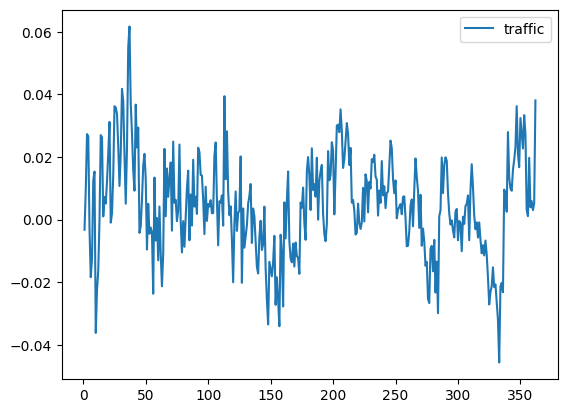

In [ ]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

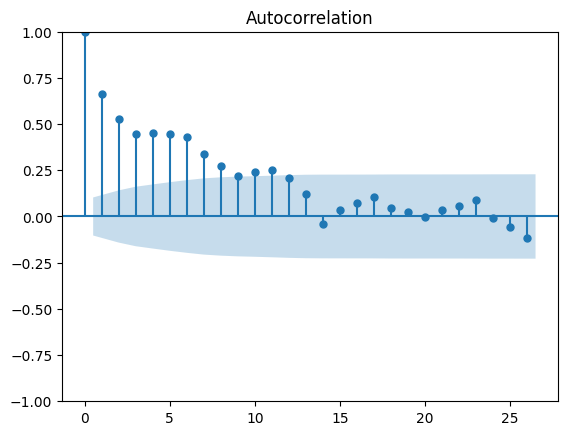

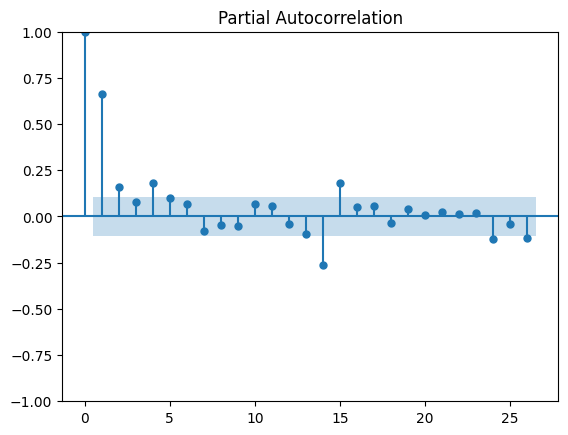

In [ ]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [ ]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.02205946123912623


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1106.131
Date:                Thu, 08 Feb 2024   AIC                          -2200.263
Time:                        09:17:09   BIC                          -2176.913
Sample:                             0   HQIC                         -2190.981
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5242      0.052     10.099      0.000       0.423       0.626
ar.L2          0.1112      0.065      1.702      0.089      -0.017       0.239
ar.L3         -0.0315      0.064     -0.489      0.6

# Step 4: Make time series predictions

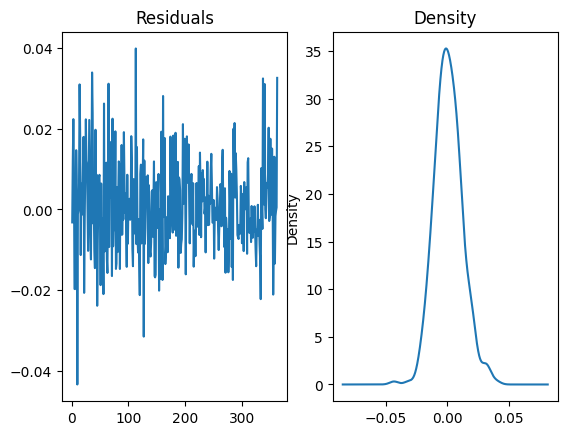

In [ ]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

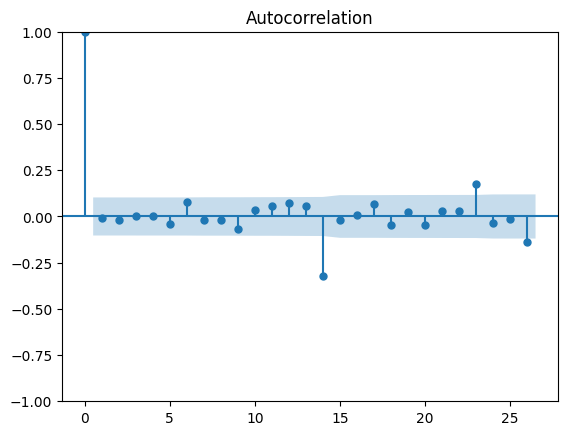

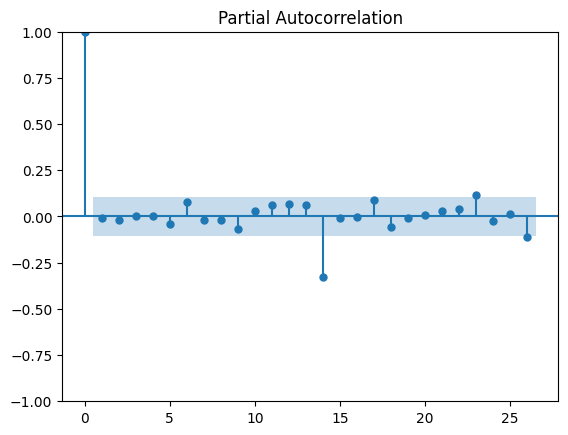

In [ ]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: >

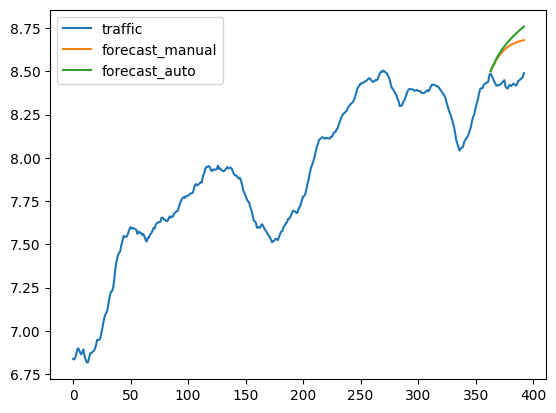

In [ ]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


# Optional: Auto-fit the ARIMA model

In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.359
Date:                Thu, 08 Feb 2024   AIC                          -2200.718
Time:                        09:15:54   BIC                          -2173.477
Sample:                             0   HQIC                         -2189.889
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.509      0.131      -0.000       0.002
ar.L1          0.5214      0.052      9.981      0.000       0.419       0.624
ar.L2          0.0934      0.065      1.434      0.152      -0.034       0.221
ar.L3         -0.0355      0.064     -0.554      0.580      -0.161       0.090
ar.L4          0.1283      0.053      2.422      0.015       0.024       0.232
ar.L5          0.1010      0.049      2.047      0.041       0.004       0.198
sigma2         0.0001   8.59e-06     14.963      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate model predictions

<Axes: >

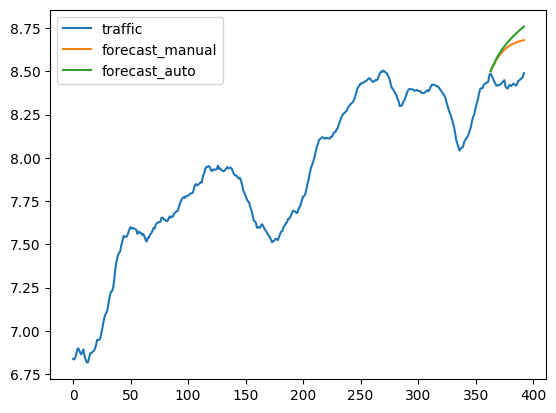

In [ ]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.18579231582173522
mape - manual: 0.022033681746722503
rmse - manual: 0.19566793034984015


In [ ]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.21700657766307713
mape - auto: 0.025732101528374015
rmse - auto: 0.23129533555027654


# Other suggestions